In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Load Data

In [2]:
# import the data set
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")

df.index = df["Date"]
df = df.sort_index(ascending=True, axis=0)
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


# Data visualization

1. Time Series Plot: Plot the entire time series to see the overall trend and seasonality.

2. Rolling Statistics: Plot rolling mean and standard deviation to check for stationarity.

3. Histogram and Density Plots: To visualize the distribution of data.

4. Box and Whisker Plots by Interval: Useful to see the spread of data across different time intervals (like years, months, or days).

5. Lag Plot or Autocorrelation Plot: Helps in identifying the nature of the relationship between an observation and its lag(s).

6. Candlestick Plot: Specifically useful for stock prices to visualize the open, high, low, and close values.

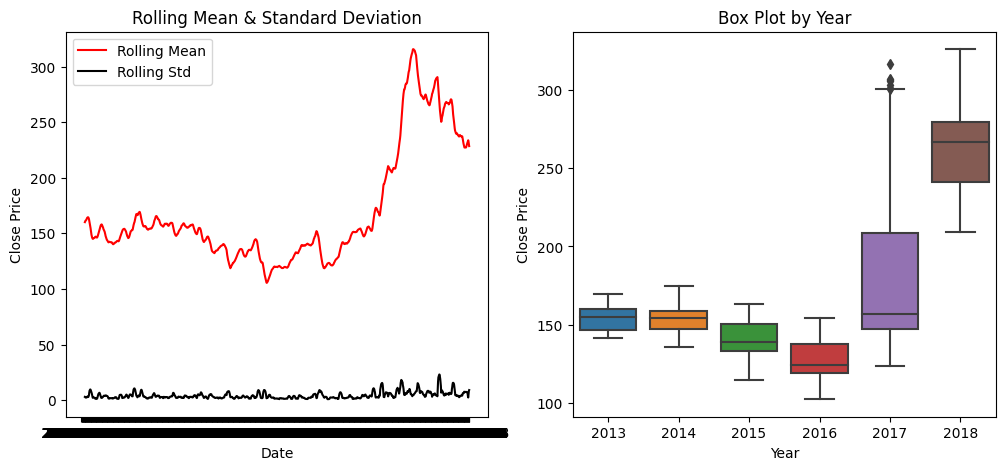

In [3]:
rolling_mean = df['Close'].rolling(window=12).mean()
rolling_std = df['Close'].rolling(window=12).std()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.subplot(1, 2, 2)
df['Year'] = [d.year for d in pd.to_datetime(df.index)]
sns.boxplot(x='Year', y='Close', data=df)
plt.title('Box Plot by Year')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

Rolling Mean & Standard Deviation Plot:
- The rolling mean shows a trend in the data, suggesting the presence of non-stationarity.
- The rolling standard deviation appears relatively stable, suggesting consistent volatility over time.

Box Plot by Year:
- There is a clear yearly seasonality with varying median values and spread.
- The spread (interquartile range) and outliers seem to increase with each year, indicating increasing volatility or price swings.

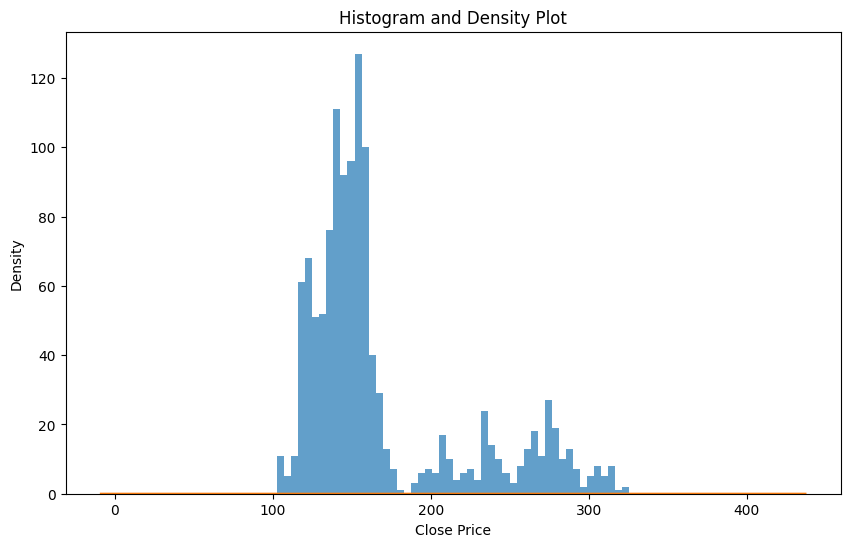

In [4]:
plt.figure(figsize=(10, 6))
df['Close'].plot(kind='hist', bins=50, alpha=0.7)
df['Close'].plot(kind='kde')
plt.title('Histogram and Density Plot')
plt.xlabel('Close Price')
plt.show()

Histogram and Density Plot:

- The data distribution is multi-modal, which could indicate different regimes or periods in the time series.

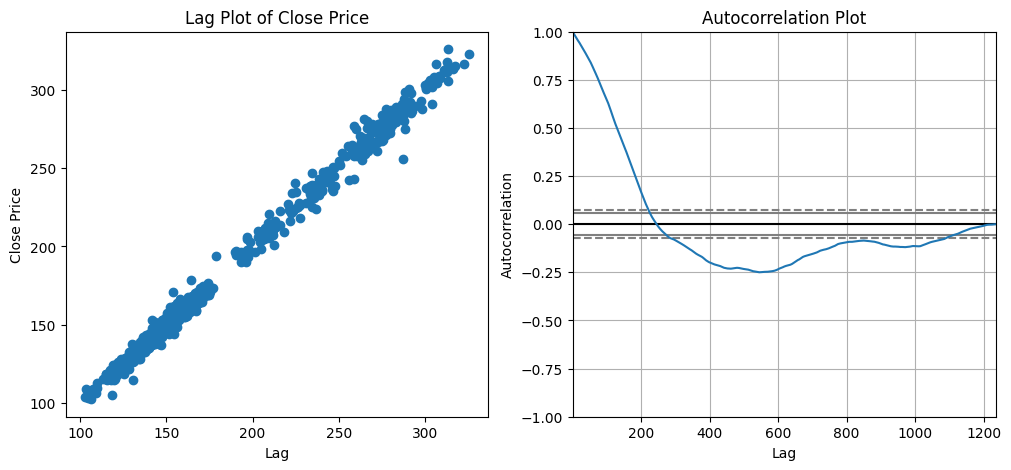

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

pd.plotting.lag_plot(df['Close'], lag=1)
plt.title('Lag Plot of Close Price')
plt.xlabel('Lag')
plt.ylabel('Close Price')

plt.subplot(1, 2, 2)
pd.plotting.autocorrelation_plot(df['Close'])
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


Lag Plot of Close Price:
- The linear pattern in the lag plot suggests a strong positive correlation with its immediate lag.

Autocorrelation Plot:
- The slow decay of the autocorrelation function indicates that the series is non-stationary.
- The correlation at lag 1 is very high, as seen in the lag plot, which is typical for time series data.

# Data preprocessing

Based on the above analysis, here are steps to preprocess the data before training the LSTM:

- Detrending: To handle non-stationarity, you might consider detrending the data. This can be done by differencing the data or by fitting a model to the trend and subtracting it from the series.
- Seasonal Adjustment: Given the yearly seasonality, a seasonal decomposition might be beneficial to separate the seasonality from the trend.
- Log Transformation: To stabilize the variance (as indicated by the increasing spread in the box plots), a log transformation might be helpful.
- Lag Features: Considering the strong autocorrelation, especially at lag 1, you should include lagged features in your input data for the LSTM.
- Outlier Handling: The presence of outliers might affect the LSTM's performance. You could cap the values at a certain percentile or use robust scaling methods.
- Normalization: LSTM models are sensitive to the scale of the input data, especially since an LSTM is using sigmoid and tanh functions. It is usually a good practice to normalize or standardize the data.

In [6]:
df['Close_log'] = np.log(df['Close'])

# Detrending
df['Close_log_diff'] = df['Close_log'].diff()

# Seasonal Decomposition
decomposition = seasonal_decompose(df['Close_log'], model='multiplicative', period=365)
df['Close_log_detrend'] = df['Close_log'] - decomposition.trend

# Handling outliers (capping at 1st and 99th percentile)
cap_low = df['Close_log_detrend'].quantile(0.01)
cap_high = df['Close_log_detrend'].quantile(0.99)
df['Close_log_detrend'] = np.clip(df['Close_log_detrend'], cap_low, cap_high)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df['Close_log_detrend_scaled'] = scaler.fit_transform(df[['Close_log_detrend']])

# Drop the NaN values created by differencing
df.dropna(inplace=True)

In [7]:
# Gernerate a new dataset that only contains Date and Close price.
def load_and_preprocess_data(file_path):
    """
    Load and preprocess data from the given file path.

    Parameters:
    file_path (str): Path to the CSV file.

    Returns:
    DataFrame: Preprocessed data.
    """
    df = pd.read_csv(file_path)
    df.index = df["Date"]
    df = df.sort_index(ascending=True, axis=0)

    new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
    for i in range(0, len(df)):
        new_dataset["Date"][i]=df["Date"][i]
        new_dataset["Close"][i]=df["Close"][i]

    new_dataset.index = new_dataset["Date"]
    new_dataset.drop("Date",axis=1,inplace=True)

    return new_dataset

def normalize_data(data):
    """
    Normalize the data using MinMaxScaler.

    Parameters:
    data (DataFrame): Data to be normalized.

    Returns:
    ndarray: Normalized data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler, scaler.fit_transform(data.to_numpy())

def split_data(normalized_data, training_ratio=0.8):
    """
    Split the data into training and validation sets.

    Parameters:
    normalized_data (ndarray): The normalized data.
    training_ratio (float): Ratio of data to be used for training (default is 0.8).

    Returns:
    tuple: Tuple containing training and validation data.
    """
    training_length = int(len(normalized_data) * training_ratio)
    return normalized_data[:training_length], normalized_data[training_length:]


def prepare_lstm_data(train_data, time_step=60):
    """
    Prepare data for LSTM training.

    Parameters:
    train_data (ndarray): Training data.
    time_step (int): Number of time steps to be used for training (default is 60).

    Returns:
    tuple: Tuple containing feature and label data for LSTM.
    """
    x_train, y_train = [], []
    for i in range(time_step, len(train_data)):
        x_train.append(train_data[i - time_step:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)


In [8]:
new_dataset = load_and_preprocess_data("NSE-Tata-Global-Beverages-Limited.csv")

# Normalize the data
scaler, scaled_data = normalize_data(new_dataset)

# Split into training and validation datasets
train_data, valid_data = split_data(scaled_data)

# Prepare LSTM training data
x_train_data, y_train_data = prepare_lstm_data(train_data)

# Reshape for LSTM input
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))


x_val_data, y_val_data = prepare_lstm_data(valid_data)
x_val_data = np.reshape(x_val_data, (x_val_data.shape[0], x_val_data.shape[1], 1))

# Model

In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# Define the LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Training

In [10]:
def train_model(model, x_train, y_train, x_val, y_val, criterion, optimizer, num_epochs):
    """
    Train and validate the LSTM model.

    Parameters:
    model (nn.Module): PyTorch LSTM model.
    x_train (Tensor): Training data features.
    y_train (Tensor): Training data labels.
    x_val (Tensor): Validation data features.
    y_val (Tensor): Validation data labels.
    criterion: Loss function.
    optimizer: Optimization algorithm.
    num_epochs (int): Number of epochs to train.

    Returns:
    model: Trained model.
    """
    train_loss_hist = []
    val_loss_hist = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)

        train_loss_hist.append(loss.item())
        val_loss_hist.append(val_loss.item())

        if (epoch % 5 == 0):
            print(f"Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    return model, train_loss_hist, val_loss_hist


## lstm

In [11]:
# Training parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1
num_epochs = 100

In [12]:
# Create the PyTorch model
lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_train_data, dtype=torch.float32)
y_train = torch.tensor(y_train_data, dtype=torch.float32)
y_train = y_train.view(-1, 1)

x_val = torch.tensor(x_val_data).float()
y_val = torch.tensor(y_val_data).float()
y_val = y_val.view(-1, 1)

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

torch.Size([928, 60, 1])
torch.Size([928, 1])
torch.Size([187, 60, 1])
torch.Size([187, 1])


In [14]:
lstm, train_loss_hist_lstm, val_loss_hist_lstm =  train_model(lstm,
                     x_train, y_train,
                     x_val, y_val,
                     criterion, optimizer, num_epochs)

Epoch 0, Training Loss: 0.09209108352661133, Validation Loss: 0.6597318649291992
Epoch 5, Training Loss: 0.04426771029829979, Validation Loss: 0.5014387965202332
Epoch 10, Training Loss: 0.012301567010581493, Validation Loss: 0.33037036657333374
Epoch 15, Training Loss: 0.011494593694806099, Validation Loss: 0.19310633838176727
Epoch 20, Training Loss: 0.009038680233061314, Validation Loss: 0.23653391003608704
Epoch 25, Training Loss: 0.006756470073014498, Validation Loss: 0.2936343848705292
Epoch 30, Training Loss: 0.0077117737382650375, Validation Loss: 0.3093118369579315
Epoch 35, Training Loss: 0.007235323544591665, Validation Loss: 0.2932254374027252
Epoch 40, Training Loss: 0.00646326644346118, Validation Loss: 0.26378777623176575
Epoch 45, Training Loss: 0.006497983355075121, Validation Loss: 0.24230681359767914
Epoch 50, Training Loss: 0.006422565784305334, Validation Loss: 0.2406257838010788
Epoch 55, Training Loss: 0.006148177664726973, Validation Loss: 0.24873191118240356
Ep

## RNN

In [15]:
input_dim = 1
hidden_dim = 64
num_layers = 4
output_dim = 1

rnn = RNN(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

rnn, train_loss_hist_rnn, val_loss_hist_rnn =  train_model(rnn,
                     x_train, y_train,
                     x_val, y_val,
                     criterion, optimizer, num_epochs)

Epoch 0, Training Loss: 0.019302964210510254, Validation Loss: 0.23471593856811523
Epoch 5, Training Loss: 0.009168410673737526, Validation Loss: 0.34520265460014343
Epoch 10, Training Loss: 0.007320117205381393, Validation Loss: 0.2530454397201538
Epoch 15, Training Loss: 0.006733826827257872, Validation Loss: 0.29022082686424255
Epoch 20, Training Loss: 0.0064964499324560165, Validation Loss: 0.2590486705303192
Epoch 25, Training Loss: 0.005819992627948523, Validation Loss: 0.2195032685995102
Epoch 30, Training Loss: 0.003573077265173197, Validation Loss: 0.10866253823041916
Epoch 35, Training Loss: 0.0034439987502992153, Validation Loss: 0.007649896666407585
Epoch 40, Training Loss: 0.0010790603701025248, Validation Loss: 0.06698102504014969
Epoch 45, Training Loss: 0.001640016445890069, Validation Loss: 0.05131319537758827
Epoch 50, Training Loss: 0.000866158923599869, Validation Loss: 0.014202037826180458
Epoch 55, Training Loss: 0.0009974269196391106, Validation Loss: 0.004528156

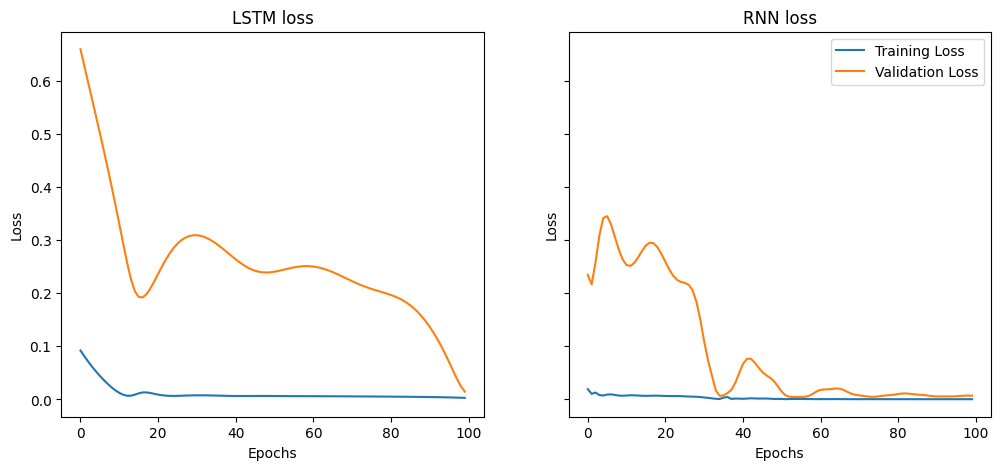

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

ax1.plot(train_loss_hist_lstm, label="Training Loss")
ax1.plot(val_loss_hist_lstm, label="Validation Loss")
ax1.set_title('LSTM loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(train_loss_hist_rnn, label="Training Loss")
ax2.plot(val_loss_hist_rnn, label="Validation Loss")
ax2.set_title('RNN loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

plt.legend()
plt.show()

# Prediction

In [17]:
def predict(model, test_data):
    """
    Make predictions using the trained LSTM model.

    Parameters:
    model (nn.Module): Trained PyTorch LSTM model.
    test_data (Tensor): Test data features.

    Returns:
    ndarray: Predictions.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(test_data)
    return predictions.numpy()

In [18]:
train_data, valid_data = split_data(scaled_data)
# Assuming test_data contains your test dataset
x_test_data, y_test_data = prepare_lstm_data(valid_data)

# Reshape for LSTM input
x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))
x_test_data = torch.tensor(x_test_data).float()

# Generate predictions
predictions_lstm = predict(lstm, x_test_data)
predictions_rnn = predict(rnn, x_test_data)

predictions_lstm = scaler.inverse_transform(predictions_lstm.reshape(-1, 1))
predictions_rnn = scaler.inverse_transform(predictions_rnn.reshape(-1, 1))

actual_values = scaler.inverse_transform(y_test_data.reshape(-1, 1))

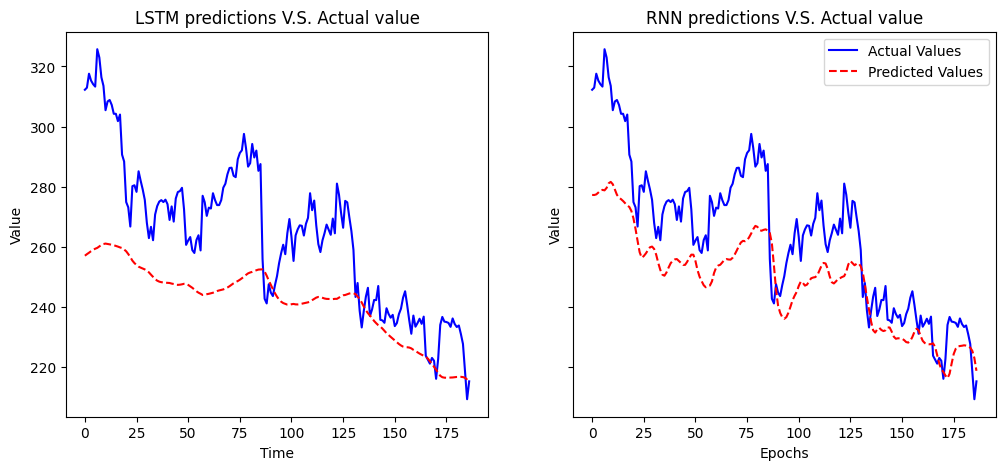

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

ax1.plot(actual_values, color='blue', label='Actual Values')
ax1.plot(predictions_lstm, color='red', linestyle='dashed', label='Predicted Values')
ax1.set_title('LSTM predictions V.S. Actual value')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')

ax2.plot(actual_values, color='blue', label='Actual Values')
ax2.plot(predictions_rnn, color='red', linestyle='dashed', label='Predicted Values')
ax2.set_title('RNN predictions V.S. Actual value')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Value')

plt.legend()
plt.show()